# Notebook to train DeepSTARR

#### Used packages and their version

In [ ]:
#### GPU environment 

# conda create --name DeepSTARR python=3.7 tensorflow-gpu=1.14.0 keras-gpu=2.2.4
# conda activate DeepSTARR
# conda install numpy=1.16.2 pandas=0.25.3 matplotlib=3.1.1 ipykernel=5.4.3
# pip install git+git://github.com/AvantiShri/shap.git@master
# pip install 'h5py<3.0.0'
# pip install deeplift==0.6.13.0
# pip install keras-tuner==1.0.1


"""
# FASTA files with DNA sequences of genomic regions from train/val/test sets
!wget 'https://data.starklab.org/almeida/DeepSTARR/Data/Sequences_Train.fa'
!wget 'https://data.starklab.org/almeida/DeepSTARR/Data/Sequences_Val.fa'
!wget 'https://data.starklab.org/almeida/DeepSTARR/Data/Sequences_Test.fa'

# Files with USelopmental and housekeeping activity of genomic regions from train/val/test sets
!wget 'https://data.starklab.org/almeida/DeepSTARR/Data/Sequences_activity_Train.txt'
!wget 'https://data.starklab.org/almeida/DeepSTARR/Data/Sequences_activity_Val.txt'
!wget 'https://data.starklab.org/almeida/DeepSTARR/Data/Sequences_activity_Test.txt'
"""

In [1]:
import tensorflow as tf

import keras
import keras.layers as kl
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers import BatchNormalization, InputLayer, Input
from keras import models
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

import sys, os
#sys.path.append('Neural_Network_DNA_Demo/')
#from helper # from https://github.com/const-ae/Neural_Network_DNA_Demo
import IOHelper, SequenceHelper 

import random
random.seed(1234)

from scipy import stats

/wynton/home/ahituv/fongsl/micromamba/envs/DeepSTARR/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/wynton/home/ahituv/fongsl/micromamba/envs/DeepSTARR/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/wynton/home/ahituv/fongsl/micromamba/envs/DeepSTARR/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

## Load data

In [115]:
CL = "hepg2"
os.chdir(f"/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/{CL}.reg.all")
PREFIX = "reg.all"

In [3]:
# function to load sequences and enhancer activity
def prepare_input(set, prefix):
    # Convert sequences to one-hot encoding matrix
    file_seq = str(f"{prefix}.Sequences_" + set + ".fa")
    input_fasta_data_A = IOHelper.get_fastas_from_file(file_seq, uppercase=True)

    # get length of first sequence
    sequence_length = len(input_fasta_data_A.sequence.iloc[0])

    # Convert sequence to one hot encoding matrix
    seq_matrix_A = SequenceHelper.do_one_hot_encoding(input_fasta_data_A.sequence, sequence_length,
                                                      SequenceHelper.parse_alpha_to_seq)
    print(seq_matrix_A.shape)
    
    X = np.nan_to_num(seq_matrix_A) # Replace NaN with zero and infinity with large finite numbers
    X_reshaped = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

    Activity = pd.read_table(f"{prefix}.Sequences_activity_" + set + ".txt")
    
    # SCALE DATA
    sc = StandardScaler()
    Y_train_sc = pd.DataFrame(sc.fit_transform(Activity[Activity.columns[1:]]))
    Y = []

    for i in Y_train_sc.columns:
        Y.append(Y_train_sc[i])
    Y = []
   
    print(set)

    return input_fasta_data_A.sequence, seq_matrix_A, X_reshaped, Y, 

In [4]:
# Data for train/val/test sets
X_train_sequence, X_train_seq_matrix, X_train, Y_train = prepare_input("Train", PREFIX)
X_valid_sequence, X_valid_seq_matrix, X_valid, Y_valid = prepare_input("Val", PREFIX)
X_test_sequence, X_test_seq_matrix, X_test, Y_test = prepare_input("Test", PREFIX)

(118242, 271, 4)
Train
(5314, 271, 4)
Val
(4755, 271, 4)
Test


In [162]:
    # SCALE DATA
    sc = StandardScaler()
    Y_train_sc = pd.DataFrame(sc.fit_transform(Activity[Activity.columns[1:]]))
    Y = []

    for i in Y_train_sc.columns:
        Y.append(Y_train_sc[i])
    
 #   print(set)

#    return input_fasta_data_A.sequence, seq_matrix_A, X_reshaped, Y

In [167]:
Y

[0      -1.248042
 1      -0.374312
 2      -1.004287
 3       1.196027
 4      -0.931834
           ...   
 4750   -0.379696
 4751   -0.117361
 4752   -0.270190
 4753   -1.536129
 4754   -0.540525
 Name: 1, Length: 4755, dtype: float64,
 0      -0.924061
 1      -0.693572
 2      -1.568402
 3       1.345341
 4      -1.067046
           ...   
 4750   -1.568402
 4751   -0.219697
 4752   -0.639278
 4753   -0.639278
 4754   -0.778073
 Name: 0, Length: 4755, dtype: float64,
 0      -1.248042
 1      -0.374312
 2      -1.004287
 3       1.196027
 4      -0.931834
           ...   
 4750   -0.379696
 4751   -0.117361
 4752   -0.270190
 4753   -1.536129
 4754   -0.540525
 Name: 1, Length: 4755, dtype: float64]

## Build DeepSTARR model

In [5]:
### Additional metrics
from scipy.stats import spearmanr
def Spearman(y_true, y_pred):
     return ( tf.py_function(spearmanr, [tf.cast(y_pred, tf.float32), 
                       tf.cast(y_true, tf.float32)], Tout = tf.float32) )


In [6]:
model_name="DeepSTARR_ATAC"
pred_task = "reg"
params = {'batch_size': 64,
          'epochs': 5, # 100
          'early_stop': 10,
          'kernel_size1': 7,
          'kernel_size2': 3,
          'kernel_size3': 5,
          'kernel_size4': 3,
          'lr': 0.002,
          'num_filters': 256,
          'num_filters2': 60,
          'num_filters3': 60,
          'num_filters4': 120,
          'n_conv_layer': 4,
          'n_add_layer': 2,
          'dropout_prob': 0.4,
          'dense_neurons1': 256,
          'dense_neurons2': 256,
          'pad':'same', 
          "n_nucleotides":4, 
          "seq_len":271,
          "pred_task": pred_task, #"class", # or "reg"
          "n_pred_tasks": 2 # or regression
         }


In [7]:
def DeepSTARR(params=params):
    
    lr = params['lr']
    dropout_prob = params['dropout_prob']
    n_conv_layer = params['n_conv_layer']
    n_add_layer = params['n_add_layer']
    
    # body
    input = kl.Input(shape=(params['seq_len'], params['n_nucleotides']))
    x = kl.Conv1D(params['num_filters'], kernel_size=params['kernel_size1'],
                  padding=params['pad'],
                  name='Conv1D_1st')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)

    for i in range(1, n_conv_layer):
        x = kl.Conv1D(params['num_filters'+str(i+1)],
                      kernel_size=params['kernel_size'+str(i+1)],
                      padding=params['pad'],
                      name=str('Conv1D_'+str(i+1)))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    # dense layers
    for i in range(0, n_add_layer):
        x = kl.Dense(params['dense_neurons'+str(i+1)],
                     name=str('Dense_'+str(i+1)))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_prob)(x)
    bottleneck = x
    
    # heads per task (developmental and housekeeping enhancer activities)
    
    # SF added below. Accommodate linear and classification tasks.
    pred_task = params["pred_task"] 
    
    if pred_task == "reg":
        activation_ = "linear"
        loss_ = ['mse']*params['n_pred_tasks']
        metrics_ = Spearman
        
    elif pred_task == "class":
        activation_ = tf.nn.softmax
        loss_ = ['binary_crossentropy']*params['n_pred_tasks']
        metrics_ = 'accuracy'
        
    # SF end additions
    
    tasks = ['US', 'ctrl']  # for naming
    outputs = []
    for task in tasks:
        outputs.append(kl.Dense(1, activation=activation_, name=str('Dense_' + task))(bottleneck))  # changed activation="linear"

    model = keras.models.Model([input], outputs)
    model.compile(keras.optimizers.Adam(lr=lr),
                  loss = loss_,  # SF changed loss=['mse', 'mse'], # loss
                  loss_weights=[1, 1], # loss weigths to balance
                  metrics=[metrics_]) # additional track metric

    return model, params

# Training DeepSTARR

In [8]:
def train(selected_model, X_train, Y_train, X_valid, Y_valid, params):

    my_history=selected_model.fit(X_train, Y_train,
                                  validation_data=(X_valid, Y_valid),
                                  batch_size=params['batch_size'], epochs=params['epochs'],
                                  callbacks=[EarlyStopping(patience=params['early_stop'], monitor="val_loss", restore_best_weights=True),
                                             History()])
    
    return selected_model, my_history

In [9]:
main_model, main_params = DeepSTARR()

main_model, my_history = train(main_model, X_train, Y_train, X_valid, Y_valid, main_params)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



2024-03-07 13:13:15.250586: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2024-03-07 13:13:15.330519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:02:00.0
2024-03-07 13:13:15.330798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 1 with properties: 
name: NVIDIA GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:03:00.0
2024-03-07 13:13:15.331051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 2 with properties: 
name: NVIDIA GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:81:00.0
2024-03-07 13:13:15.331298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 3 with properties: 
name: NVIDIA GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 


Train on 118242 samples, validate on 5314 samples
Epoch 1/5


2024-03-07 13:13:18.936950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:02:00.0
2024-03-07 13:13:18.937310: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 1 with properties: 
name: NVIDIA GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:03:00.0
2024-03-07 13:13:18.937579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 2 with properties: 
name: NVIDIA GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:81:00.0
2024-03-07 13:13:18.937815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 3 with properties: 
name: NVIDIA GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:82:00.0
2024-03-07 13:13:18.937870: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library 

118242/118242 [==============================] - 38s 318us/step - loss: 4.7782 - Dense_US_loss: 2.3299 - Dense_ctrl_loss: 2.4482 - Dense_US_Spearman: 0.3712 - Dense_ctrl_Spearman: 0.3816 - val_loss: 3.7622 - val_Dense_US_loss: 1.8797 - val_Dense_ctrl_loss: 1.8825 - val_Dense_US_Spearman: 0.4915 - val_Dense_ctrl_Spearman: 0.5047
Epoch 2/5
118242/118242 [==============================] - 26s 219us/step - loss: 3.9806 - Dense_US_loss: 1.9670 - Dense_ctrl_loss: 2.0136 - Dense_US_Spearman: 0.4944 - Dense_ctrl_Spearman: 0.5107 - val_loss: 5.1150 - val_Dense_US_loss: 2.5171 - val_Dense_ctrl_loss: 2.5978 - val_Dense_US_Spearman: 0.5118 - val_Dense_ctrl_Spearman: 0.5195
Epoch 3/5
118242/118242 [==============================] - 26s 219us/step - loss: 3.7260 - Dense_US_loss: 1.8482 - Dense_ctrl_loss: 1.8779 - Dense_US_Spearman: 0.5353 - Dense_ctrl_Spearman: 0.5550 - val_loss: 3.6484 - val_Dense_US_loss: 1.8270 - val_Dense_ctrl_loss: 1.8214 - val_Dense_US_Spearman: 0.5419 - val_Dense_ctrl_Spearma

# Evaluating the Model

### Model performance: mean squared error (MSE) and Pearson (PCC) and Spearman (SCC) correlation coefficients

In [10]:
# create functions
def summary_statistics(X, Y, set, task):
    pred = main_model.predict(X, batch_size=main_params['batch_size'])
    if task =="US":
        i=0
    if task =="ctrl":
        i=1
    print(set + ' MSE ' + task + ' = ' + str("{0:0.2f}".format(mean_squared_error(Y, pred[i].squeeze()))))
    print(set + ' PCC ' + task + ' = ' + str("{0:0.2f}".format(stats.pearsonr(Y, pred[i].squeeze())[0])))
    print(set + ' SCC ' + task + ' = ' + str("{0:0.2f}".format(stats.spearmanr(Y, pred[i].squeeze())[0])))
    return pred[i]

In [62]:
def summary_statistics(X, Y, set, task, i):
    pred = main_model.predict(X, batch_size=main_params['batch_size'])
    print(i)
    if main_params['pred_task'] == "reg":
        print(set +' MSE ' + task + ' = ' + "{0:0.2f}".format(mean_squared_error(Y[i], pred[i].squeeze())))
        print(set + ' PCC ' + task + ' = ' + str("{0:0.2f}".format(stats.pearsonr(Y[i], pred[i].squeeze())[0])))
        print(set + ' SCC ' + task + ' = ' + str("{0:0.2f}".format(stats.spearmanr(Y[i], pred[i].squeeze())[0])))
    else:
        
        print(set, "accuracy" + task + " = " + str("{0:0.2f}".format(accuracy_score(Y[i], pred[i].squeeze()))))
        print(set, "f1" + task + " = " + str("{0:0.2f}".format(f1_score(Y[i], pred[i].squeeze()))))

    return pred

In [67]:
pred

[array([[1.2882556 ],
        [2.0829573 ],
        [0.32795942],
        ...,
        [1.9439896 ],
        [1.651781  ],
        [1.4668834 ]], dtype=float32),
 array([[1.2147305 ],
        [2.1619534 ],
        [0.05254531],
        ...,
        [2.0321994 ],
        [1.648738  ],
        [1.428699  ]], dtype=float32)]

In [51]:

task = 'US'
i=0
Y = Y_test

In [85]:
Y

[0       1.019027
 1       1.383546
 2       0.000000
 3       4.608091
 4       0.792896
           ...   
 4750    0.000000
 4751    2.132980
 4752    1.469412
 4753    1.469412
 4754    1.249907
 Name: US, Length: 4755, dtype: float64,
 0       0.466838
 1       1.882701
 2       0.861839
 3       4.427402
 4       0.979248
           ...   
 4750    1.873975
 4751    2.299085
 4752    2.051428
 4753    0.000000
 4754    1.613356
 Name: ctrl, Length: 4755, dtype: float64]

In [64]:
test_us_pred = summary_statistics(X_test, Y_test, "test", "US", 0)
test_ctrl_pred = summary_statistics(X_test, Y_test, "test", "ctrl", 1)

0
test MSE US = 1.68
test PCC US = 0.60
test SCC US = 0.54
1
test MSE ctrl = 1.73
test PCC ctrl = 0.61
test SCC ctrl = 0.56


In [76]:
pd.merge(pd.DataFrame(test_us_pred[0]), pd.DataFrame(test_us_pred[1]), left_index=True, right_index=True)

,0_x,0_y
0,1.288256,1.214731
1,2.082957,2.161953
2,0.327959,0.052545
3,3.478493,3.512118
4,1.669486,1.712325
...,...,...
4750,1.778760,1.702008
4751,3.134439,3.193097
4752,1.943990,2.032199
4753,1.651781,1.648738


In [86]:
X_test.shape

(4755, 271, 4)

In [ ]:
# run for each set and enhancer type
train_us_pred = summary_statistics(X_train, Y_train[0], "train", "US")
train_ctrl_pred = summary_statistics(X_train, Y_train[1], "train", "ctrl")
val_us_pred = summary_statistics(X_valid, Y_valid[0], "validation", "US")
val_ctrl_pred = summary_statistics(X_valid, Y_valid[1], "validation", "ctrl")

test_us_pred = summary_statistics(X_test, Y_test[0], "test", "US")
test_ctrl_pred = summary_statistics(X_test, Y_test[1], "test", "ctrl")

preds = pd.merge(pd.DataFrame(test_us_pred), pd.DataFrame(test_ctrl_pred), left_index=True, right_index=True)
preds.columns = ["pred_US", "pred_ctrl"]

In [13]:
# write actual and predicted to 
t = pd.merge(pd.DataFrame(Y_test).T, preds, left_index=True, right_index=True)
t.to_csv(f"{model_name}.preds.tsv", sep='\t', index=False)

# prediction v. test set results below

In [14]:
t.corr()

,US,ctrl,pred_US,pred_ctrl
US,1.000000,0.918129,0.604846,0.600866
ctrl,0.918129,1.000000,0.611492,0.611431
pred_US,0.604846,0.611492,1.000000,0.997292
pred_ctrl,0.600866,0.611431,0.997292,1.000000


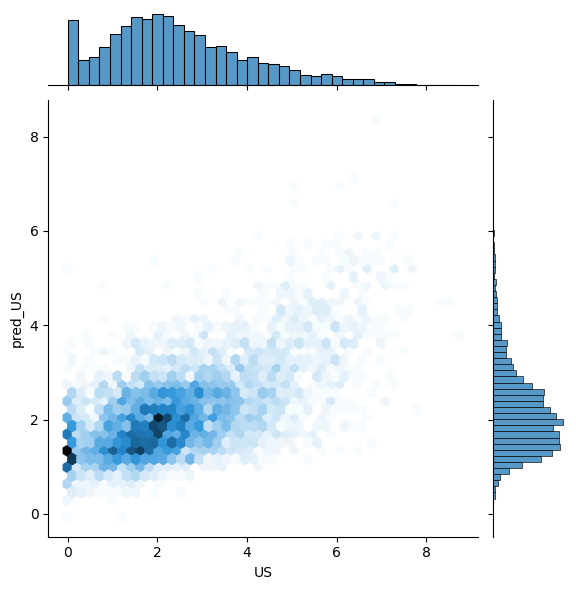

In [15]:
import seaborn as sns
sns.jointplot(x="US", y="pred_US", data=t, kind="hex")

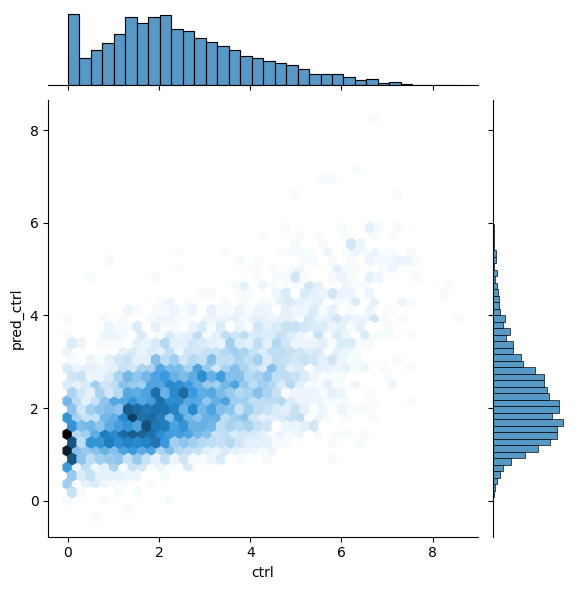

In [17]:
sns.jointplot(x="ctrl", y="pred_ctrl", data=t, kind="hex")

In [19]:
t["ctrl-us"]= t["ctrl"] - t["US"]
t["pred_ctrl-pred_us"]= t["pred_ctrl"] - t["pred_US"]

In [24]:
t[["ctrl-us", "pred_ctrl-pred_us"]].corr(method="spearman")

,ctrl-us,pred_ctrl-pred_us
ctrl-us,1.000000,0.131642
pred_ctrl-pred_us,0.131642,1.000000


<AxesSubplot:xlabel='ctrl-us', ylabel='pred_ctrl-pred_us'>

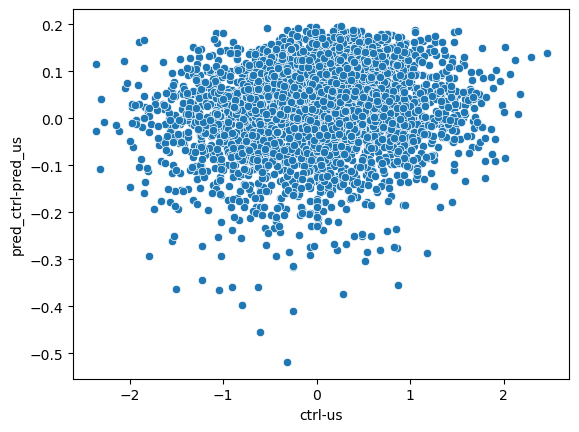

In [77]:
x = "ctrl-us"
y = "pred_ctrl-pred_us"
sns.scatterplot(x=x,y=y, data=t)

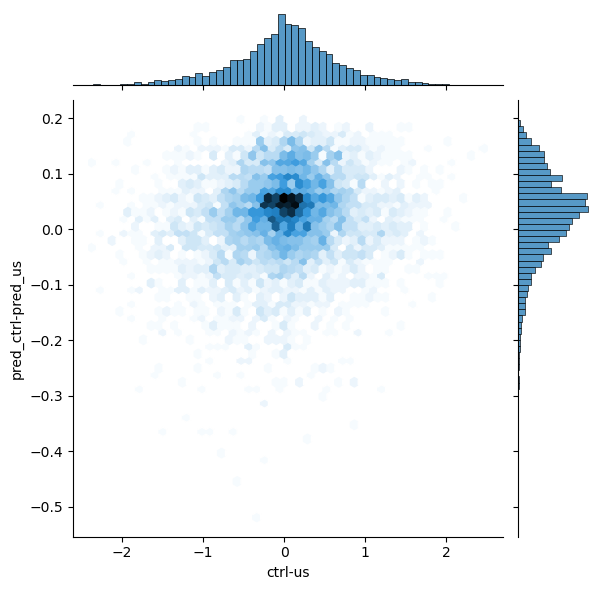

In [78]:
sns.jointplot(x=x,y=y, data=t, kind="hex")

# subset test set by differential accessibility calls from DESEQ2

In [95]:
DIFF_ACC = f"/wynton/group/ahituv/data/US-MPRA/ATAC-seq/Diffbind_results/{CL}_deseq2-nondiff.in.diffAcc.bed"
dif_acc = pd.read_csv(DIFF_ACC, sep='\t', header=None, 
                      names=["#chr_da", "start_da", "end_da", "id_da", 
                      "#chr_peak","start_peak", "end_peak", "type" ]
                     )


In [99]:
# get true differentially accessible peaks 
test_dif_acc = set(dif_acc.loc[dif_acc["#chr_peak"] == "chr8", "type"])

In [101]:
test_data = pd.read_csv("reg.all.Sequences_activity_Test.txt", sep='\t')


In [104]:
test_diffacc_idx = test_data.loc[test_data["type"].isin(test_dif_acc)].index

In [108]:
test_diffacc_pred = t.iloc[test_diffacc_idx].copy()

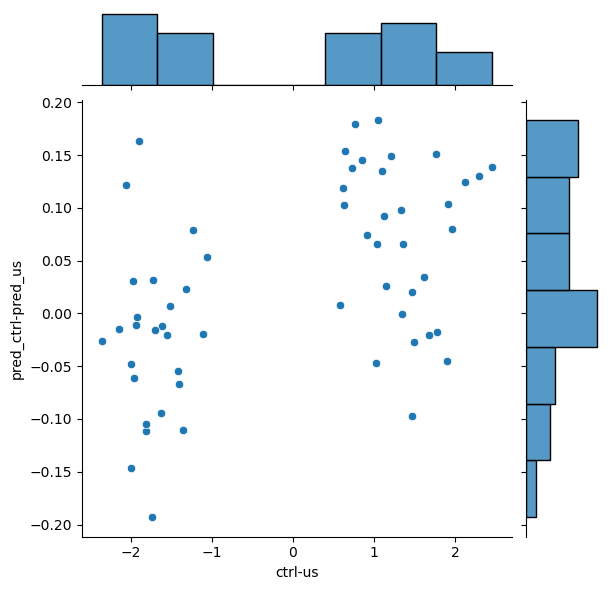

In [110]:
sns.jointplot(x=x,y=y, data=test_diffacc_pred)

In [112]:
test_diffacc_pred[[x,y]].corr(method="spearman")

,ctrl-us,pred_ctrl-pred_us
ctrl-us,1.000000,0.405471
pred_ctrl-pred_us,0.405471,1.000000
